In [26]:
from astropy.time import Time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as const

import kepler_solver

In [2]:
%config InlineBackend.figure_format = 'retina'

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.6 * fs,
          'ytick.labelsize': 0.6 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

In [4]:
%%time
n = 25000
period_range = np.linspace(100, 120, n)
least_squares = np.zeros(n)

for i, period in enumerate(period_range):
    folded_period = planet["time"] % period
    order = np.argsort(folded_period)
    folded_period = folded_period[order]
    rvs = planet["rv"][order].values
    errors = planet["error"][order].values
    
    least_squares[i] = np.sum(((rvs[1:] - rvs[:-1]))**2)

CPU times: user 30.8 s, sys: 130 ms, total: 30.9 s
Wall time: 31.2 s


In [5]:
period = period_range[least_squares.argmin()]
print(period)


data_times = planet["time"] % period
order = np.argsort(data_times)
data_times = data_times[order]
data_rvs = planet["rv"][order].values
data_errors = planet["error"][order].values

111.4660586423457


# let's fit it

In [6]:
import emcee

In [7]:
def get_rvs(times, P, k_star, t_p, gamma, omega, e):
    return np.array([kepler_solver.radial_velocity(P=P, k_star=k_star, t=t,
                                                   t_p=t_p, gamma=gamma, omega=omega, e=e) for t in times])

def log_prior(theta):
    bounds = [(110, 112), (0.2, 0.7), (10.2, 11.2), (-1, 1), (0.01, 2 * np.pi), (0, 1)]
    for i in range(len(bounds)):
        if theta[i] < bounds[i][0] or theta[i] >= bounds[i][1]:
            return -np.inf
    return 0.0
    
def log_likelihood(theta, data_times, data_rvs, data_errors):
    P, k_star, t_p, gamma, omega, e = theta
    model_rvs = get_rvs(data_times, P=P, k_star=k_star, t_p=t_p,
                        gamma=gamma, omega=omega, e=e)
    
    sigma2 = data_errors**2
    return -0.5 * np.sum((data_rvs - model_rvs)**2 / sigma2 + np.log(sigma2))

def log_prob(theta, data_times, data_rvs, data_errors):
    prior = log_prior(theta)
    if not np.isfinite(prior):
        return prior
    else:
        return log_likelihood(theta, data_times, data_rvs, data_errors) + prior


initial_guesses = [111.466, 0.4748, 10.7, -0.1, 5, 0.92]
pos = initial_guesses + 1e-4 * np.random.randn(16, len(initial_guesses))
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers=nwalkers, ndim=ndim, log_prob_fn=log_prob,
                                args=(planet["time"], planet["rv"], planet["error"]))
_ = sampler.run_mcmc(pos, 5000, progress=True)

100%|███████████████████████████████████████| 5000/5000 [07:18<00:00, 11.39it/s]


In [9]:
samples = sampler.get_chain(discard=1000, flat=True)

array([ 1.11430754e+02,  4.70560290e-01,  1.09098903e+01, -1.58430032e-03,
        5.24963182e+00,  9.32539699e-01])

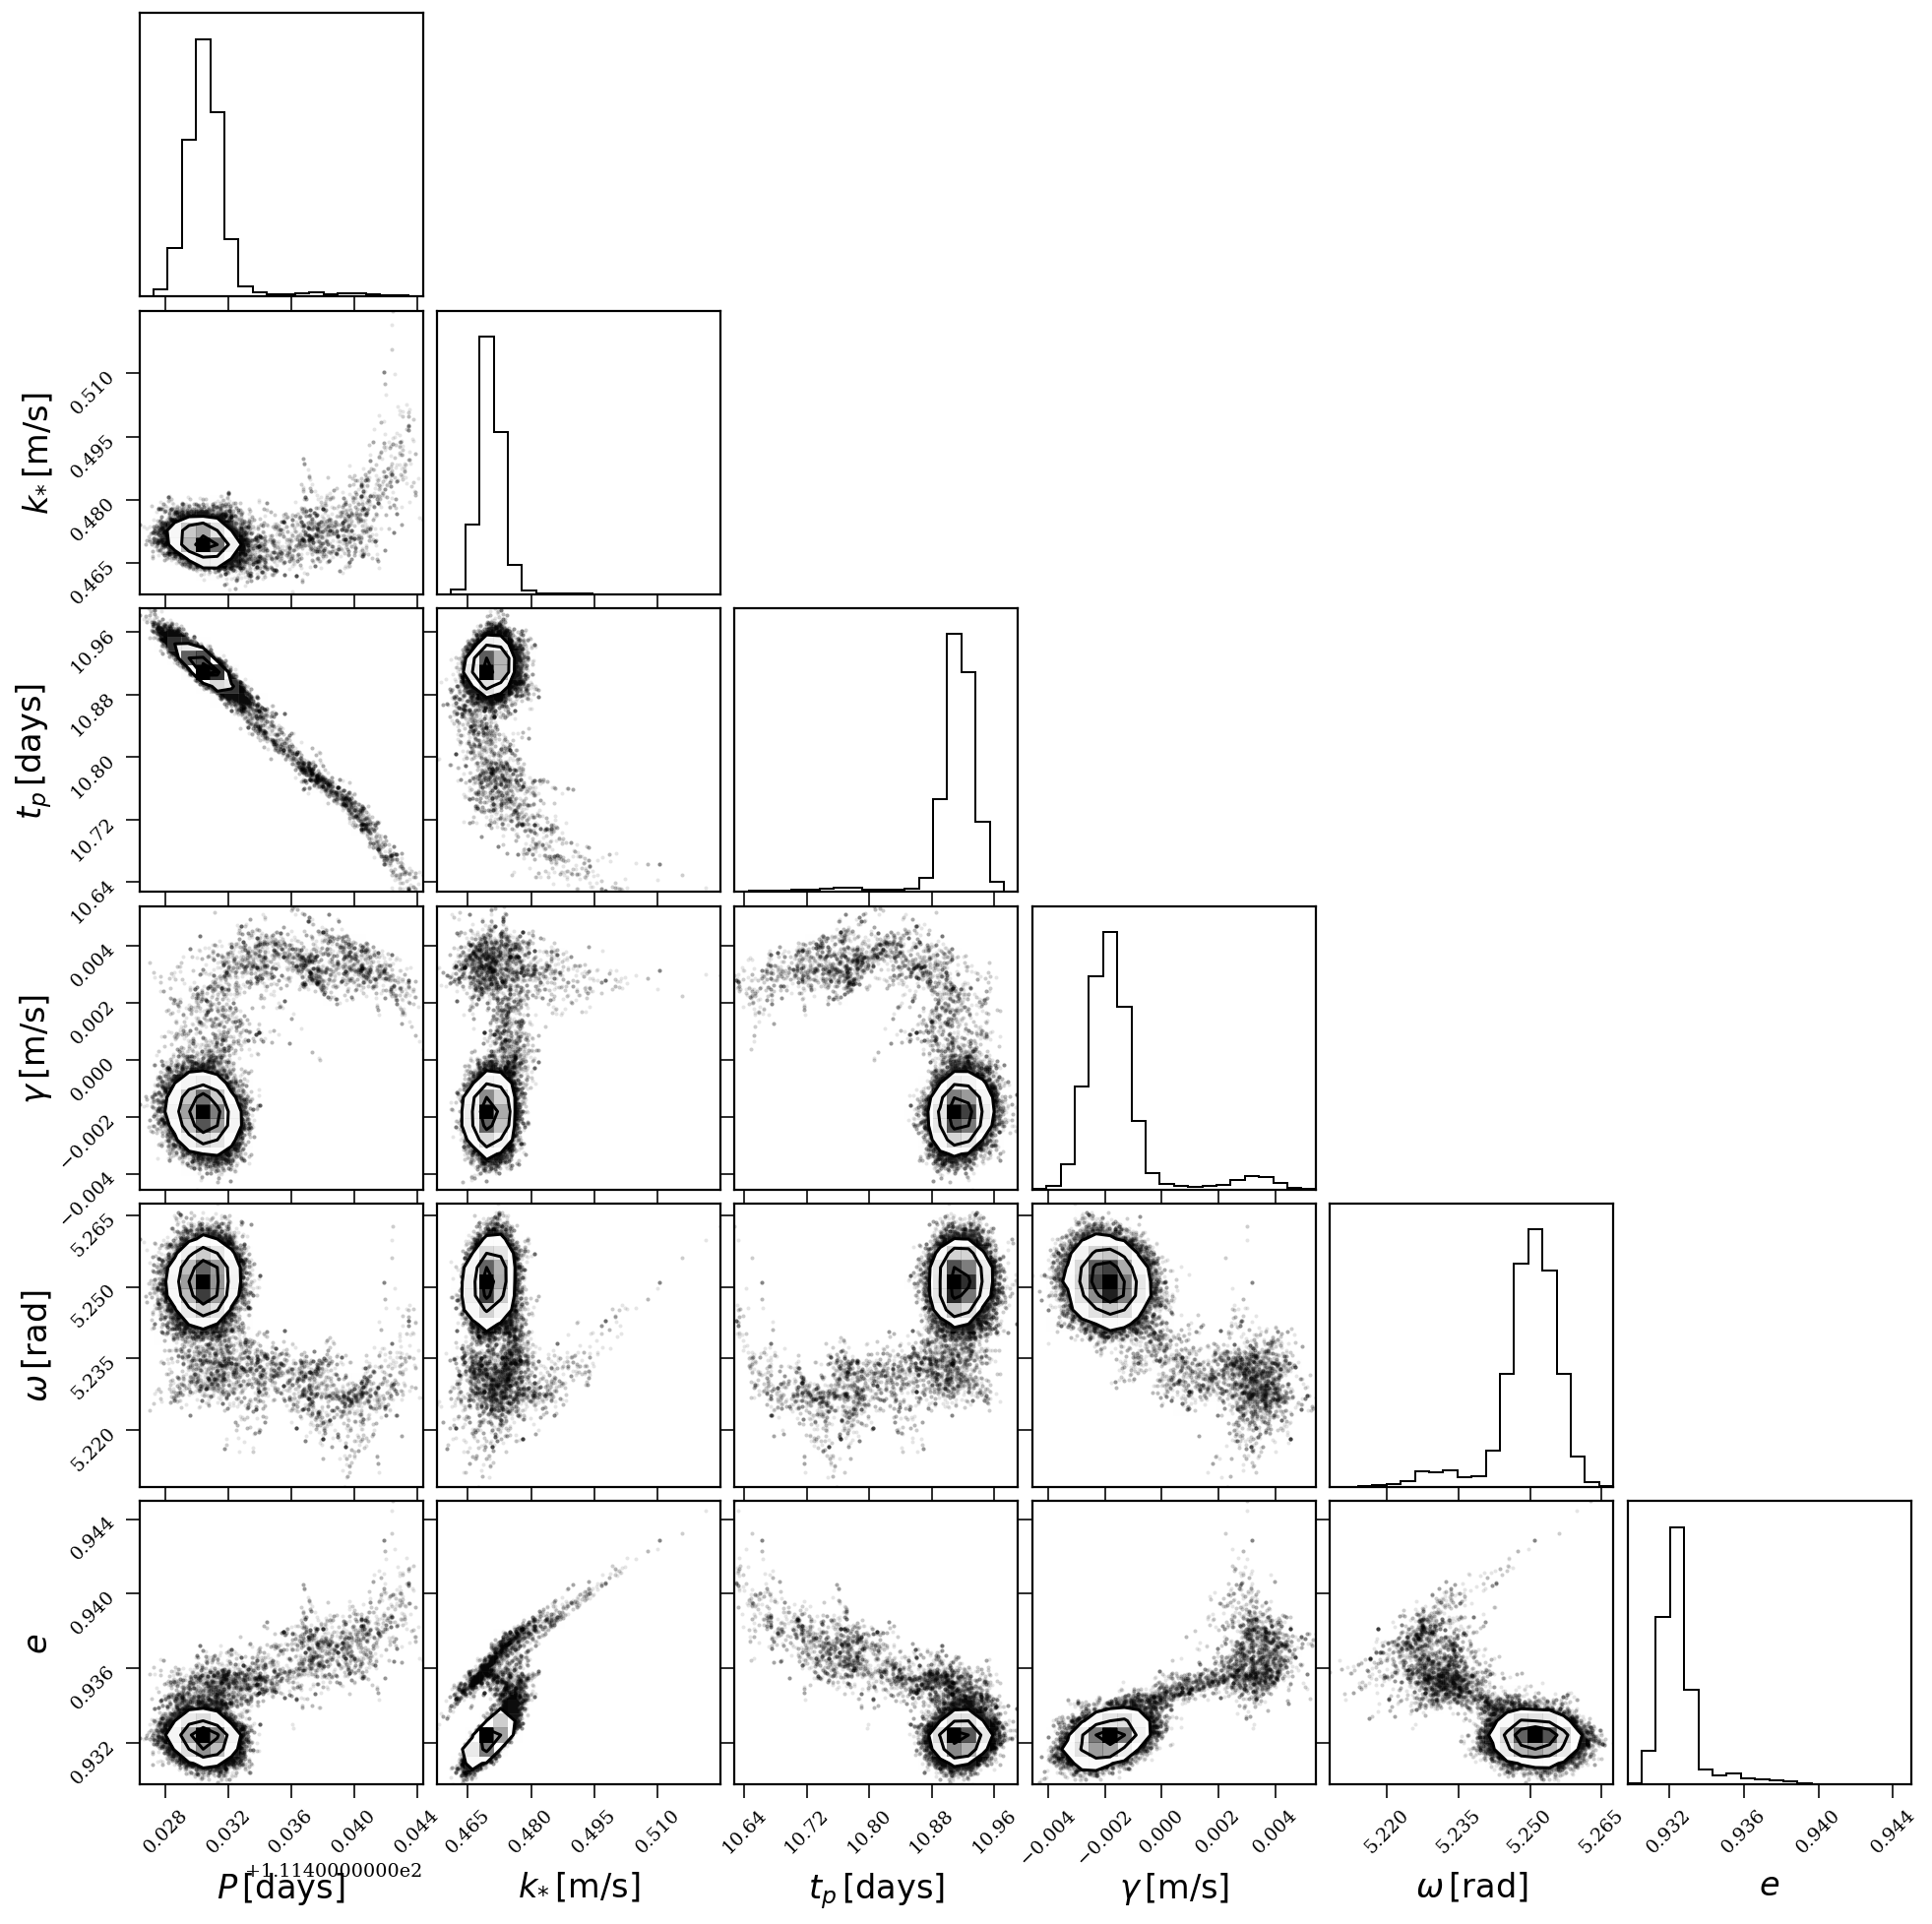

In [10]:
import corner

# update various fontsizes to match
params = {'axes.labelsize': 0.7*fs,
          'xtick.labelsize': 0.4 * fs,
          'ytick.labelsize': 0.4 * fs,}
plt.rcParams.update(params)

fig = corner.corner(
    samples, labels=[r"$P\, [{\rm days}]$", r"$k_{*}\, [{\rm m/s}]$", r"$t_p\, [{\rm days}]$", r"$\gamma\, [{\rm m / s}]$", r"$\omega \, [{\rm rad}]$", r"$e$"]
);

# plt.savefig("corner.pdf", format="pdf", bbox_inches="tight")

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.6 * fs,
          'ytick.labelsize': 0.6 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

samples.mean(axis=0)

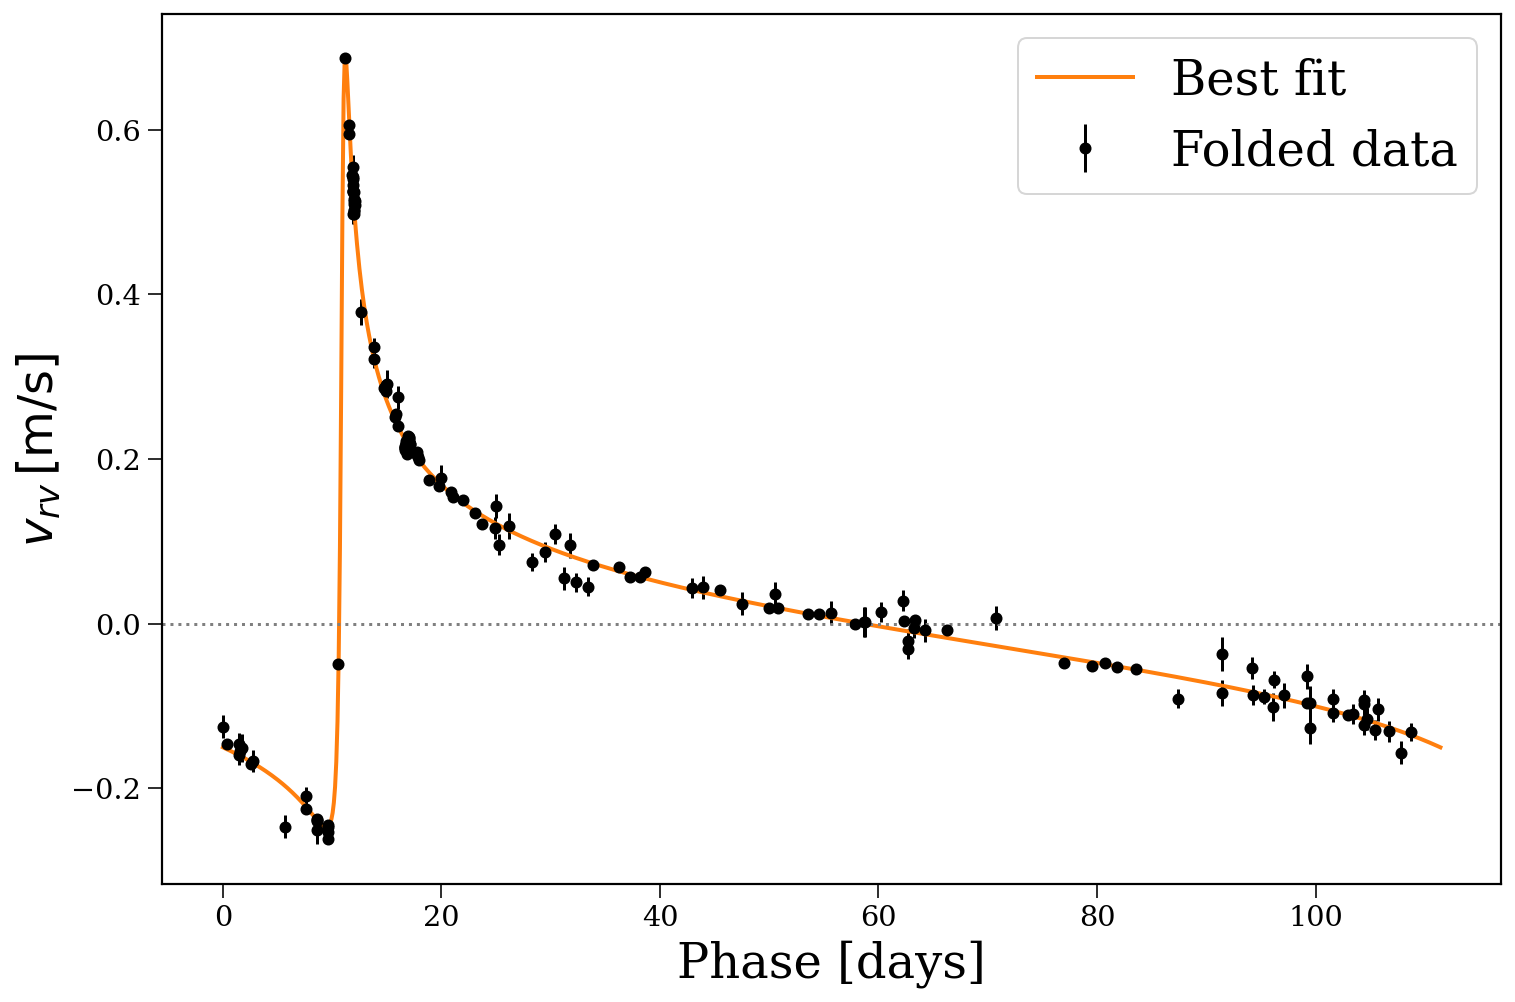

In [21]:
fig, ax = plt.subplots()

ax.errorbar(x=data_times, y=data_rvs, yerr=data_errors, fmt=".",
            color="black", markersize=10, label="Folded data")

fit = np.median(samples, axis=0)
period = fit[0]

data_times = planet["time"] % period
order = np.argsort(data_times)
data_times = data_times[order]
data_rvs = planet["rv"][order].values
data_errors = planet["error"][order].values

model_times = np.linspace(0, period, 1000)
model_rvs = get_rvs(model_times, *fit)
ax.plot(model_times, model_rvs, color="tab:orange", lw=2, label="Best fit")

ax.axhline(0, color="grey", linestyle="dotted")

ax.set_xlabel("Phase [days]")
ax.set_ylabel(r"$v_{rv} \, [{\rm m /s}]$")

ax.legend()

plt.savefig("fit.pdf", format="pdf", bbox_inches="tight")

plt.show()

In [126]:
def planet_mass(P, k_star, e, m_star=1 * u.Msun, i=np.pi/3 * u.rad):
    return k_star * (2 * np.pi * const.G / (P * (1 - e**2)))**(-1/3) / np.sin(i) * m_star**(2/3)

In [72]:
from matplotlib.colors import LogNorm

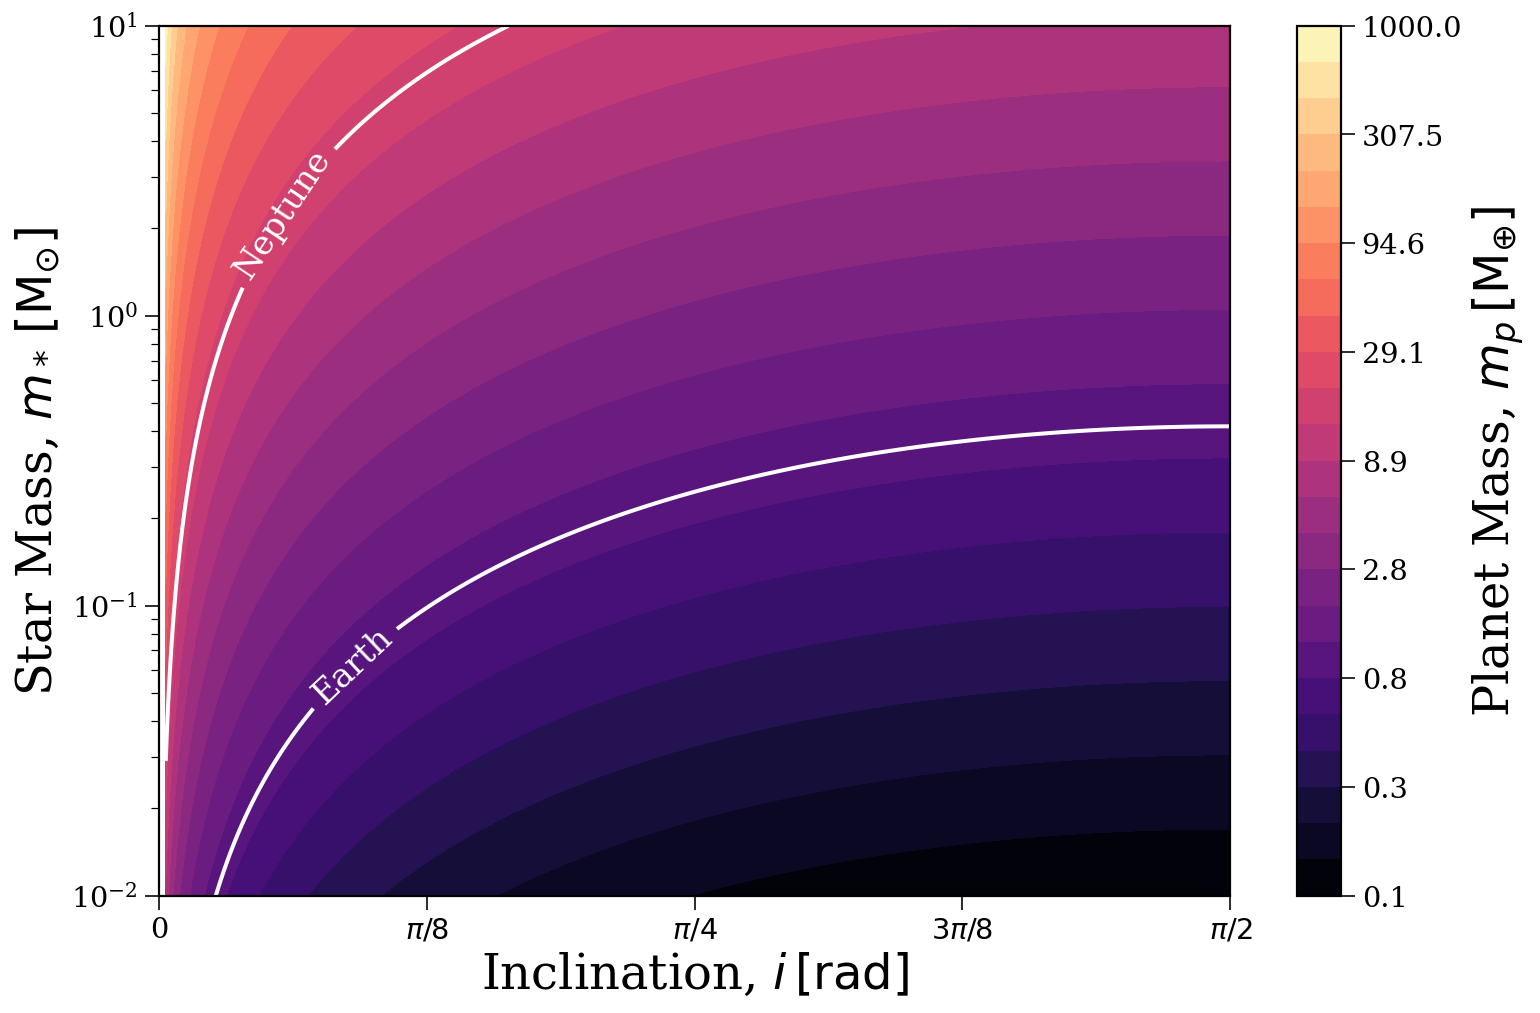

In [138]:
fig, ax = plt.subplots()

m_star_range = np.logspace(-2, 1, 500) * u.Msun
i_range = np.linspace(0.01, np.pi/2, 10000) * u.rad

MS, I = np.meshgrid(m_star_range, i_range)

m_planets = planet_mass(fit[0] * u.day,
                        fit[1] * u.m / u.s,
                        fit[-1], i=I, m_star=MS).to(u.kg) / const.M_earth

cont = ax.contourf(i_range, m_star_range, m_planets.T, norm=LogNorm(),
                   levels=np.logspace(np.log10(0.08), 3, 25), cmap="magma")

cbar = fig.colorbar(cont)
ax.set_yscale("log")

ax.set_xlim(0, np.pi/2)
ax.set_ylim(1e-2, 1e1)
ax.set_xticks([0, np.pi / 8, np.pi / 4, 3 * np.pi / 8, np.pi / 2])
ax.set_xticklabels(["0", r"$\pi / 8$", r"$\pi / 4$", r"$3 \pi / 8$", r"$\pi / 2$"])

ax.set_xlabel(r"Inclination, $i \, [{\rm rad}]$")
ax.set_ylabel(r"Star Mass, $m_* \, [{\rm M_{\odot}}]$")
cbar.set_label(r"Planet Mass, $m_p \, [{\rm M_{\oplus}}]$")

earth = ax.contour(i_range, m_star_range, m_planets.T, norm=LogNorm(),
                   levels=[1, 17], colors="white", linewidths=2)
ax.clabel(earth, [1, 17], fmt=lambda x: "Earth" if x == 1 else "Neptune",
          use_clabeltext=True, fontsize=0.7*fs, manual=[(0.2, 1e-1), (0.1, 3e0)])

plt.savefig("planet_mass.pdf", format="pdf", bbox_inches="tight")

plt.show()